<a href="https://colab.research.google.com/github/aira333/multimodalRAGapplication/blob/main/multimodalRAGapplication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q groq pymupdf pillow transformers requests sentence-transformers

In [ ]:
import os
import re
import base64
import json
import requests
from PIL import Image
import io
import fitz
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Any, Union
import time
from sentence_transformers import SentenceTransformer
from google.colab import files

In [ ]:
GROQ_API_KEY = "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"  # groq api for text processing
LLAMA_API_KEY = "c2a265cc-7612-42a5-b750-82f2948a19c3"  # alternative API

def setup_groq_client():
    import groq
    client = groq.Client(api_key=GROQ_API_KEY)
    return client

In [ ]:
def extract_content_from_pdf(pdf_path: str, output_dir: str) -> List[Dict[str, Any]]:
    print(f"Processing PDF: {pdf_path}")


    os.makedirs(output_dir, exist_ok=True)


    doc = fitz.open(pdf_path)

    documents = []


    for page_num in range(len(doc)):
        page = doc[page_num]


        text = page.get_text()
        if text.strip():
            documents.append({
                "content_type": "text",
                "text": text,
                "source": f"{os.path.basename(pdf_path)} (Page {page_num + 1})",
                "page": page_num + 1
            })


        image_list = page.get_images(full=True)
        for img_idx, img_info in enumerate(image_list):
            xref = img_info[0]

            try:
                base_image = doc.extract_image(xref)
                image_bytes = base_image["image"]


                image = Image.open(io.BytesIO(image_bytes))


                if image.width < 100 or image.height < 100:
                    continue


                img_filename = f"page{page_num+1}_img{img_idx}.jpg"
                img_path = os.path.join(output_dir, img_filename)
                image.save(img_path)


                documents.append({
                    "content_type": "image",
                    "image_path": img_path,
                    "caption": f"Image from {os.path.basename(pdf_path)}, page {page_num + 1}",
                    "source": f"{os.path.basename(pdf_path)} (Page {page_num + 1})",
                    "page": page_num + 1
                })
            except Exception as e:
                print(f"Error extracting image: {e}")


    doc.close()

    print(f"Extracted {len(documents)} content items from PDF")
    return documents


In [ ]:
class EmbeddingService:

    def __init__(self):
        # Load text embedding model
        print("Loading text embedding model...")
        self.text_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        print("Text embedding model loaded")

    def embed_text(self, text: str) -> np.ndarray:
        return self.text_model.encode(text)

    def embed_image_via_api(self, image_path: str) -> np.ndarray:
        embedding_dim = 384
        embedding = np.random.randn(embedding_dim)
        embedding = embedding / np.linalg.norm(embedding)
        return embedding

In [ ]:
class SimpleVectorDB:

    def __init__(self):
        self.documents = []
        self.text_vectors = []
        self.image_vectors = []

    def add_documents(self, documents: List[Dict[str, Any]], embedder: EmbeddingService):
        for doc in documents:
            self.documents.append(doc)

            if doc["content_type"] == "text":
                text_vector = embedder.embed_text(doc["text"])
                self.text_vectors.append(text_vector)
                self.image_vectors.append(None)

            elif doc["content_type"] == "image":
                image_vector = embedder.embed_image_via_api(doc["image_path"])
                self.image_vectors.append(image_vector)
                self.text_vectors.append(None)

    def similarity_search(self, query_vector: np.ndarray, top_k: int = 5, modality: str = "both") -> List[Dict[str, Any]]:
        results = []

        for i, doc in enumerate(self.documents):
            doc_vector = None

            if modality == "text" and doc["content_type"] == "text":
                doc_vector = self.text_vectors[i]
            elif modality == "image" and doc["content_type"] == "image":
                doc_vector = self.image_vectors[i]
            elif modality == "both":
                if doc["content_type"] == "text":
                    doc_vector = self.text_vectors[i]
                elif doc["content_type"] == "image":
                    doc_vector = self.image_vectors[i]

            if doc_vector is not None:
                similarity = np.dot(query_vector, doc_vector) / (np.linalg.norm(query_vector) * np.linalg.norm(doc_vector))

                result = doc.copy()
                result["similarity"] = float(similarity)
                results.append(result)


        results.sort(key=lambda x: x["similarity"], reverse=True)


        return results[:top_k]

In [ ]:
class MultimodalLLM:

    def __init__(self, api_key=None, provider="groq"):
        self.api_key = api_key
        self.provider = provider

        if provider == "groq" and api_key:
            self.client = setup_groq_client()
        else:
            self.client = None

    def generate_with_groq(self, query: str, context_texts: List[str], image_paths: List[str]=None) -> str:
        """Generate response using Groq API"""
        if not self.client:
            return "API key not configured"


        system_message = """You are a multimodal assistant that answers questions based on provided context.
        The context includes text and images (described by captions).
        Use this information to provide accurate and comprehensive answers."""


        context = "Context information:\n\n"
        for i, text in enumerate(context_texts):
            context += f"Text {i+1}:\n{text}\n\n"

        if image_paths and len(image_paths) > 0:
            context += "Image information:\n\n"
            for i, path in enumerate(image_paths):
                context += f"Image {i+1}: {path}\n"


        user_message = f"{context}\n\nQuestion: {query}\n\nPlease provide a comprehensive answer based on the context."


        try:
            chat_completion = self.client.chat.completions.create(
                messages=[
                    {"role": "system", "content": system_message},
                    {"role": "user", "content": user_message}
                ],
                model="llama3-8b-8192",
                max_tokens=1024
            )
            return chat_completion.choices[0].message.content
        except Exception as e:
            return f"Error generating response: {str(e)}"

    def generate_with_api(self, query: str, context_texts: List[str], image_paths: List[str]=None) -> str:
        """
        Generate response using HTTP API (works with various providers)
        This is a more generic implementation that works with many APIs
        """

        if self.provider == "groq":
            api_endpoint = "https://api.groq.com/v1/chat/completions"
        elif self.provider == "llama":
            api_endpoint = "https://api.llama-api.com/chat/completions"
        else:
            return "Unsupported provider"


        system_message = """You are a multimodal assistant that answers questions based on provided context.
        The context includes text and images (described by captions).
        Use this information to provide accurate and comprehensive answers."""


        context = "Context information:\n\n"
        for i, text in enumerate(context_texts):
            context += f"Text {i+1}:\n{text}\n\n"

        if image_paths and len(image_paths) > 0:
            context += "Image information:\n\n"
            for i, path in enumerate(image_paths):
                filename = os.path.basename(path)
                context += f"Image {i+1}: {filename}\n"


        user_message = f"{context}\n\nQuestion: {query}\n\nPlease provide a comprehensive answer based on the context."


        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {self.api_key}"
        }

        payload = {
            "model": "llama3-8b-8192",
            "messages": [
                {"role": "system", "content": system_message},
                {"role": "user", "content": user_message}
            ],
            "max_tokens": 1024
        }


        try:
            response = requests.post(api_endpoint, headers=headers, json=payload)
            response.raise_for_status()

            result = response.json()
            return result["choices"][0]["message"]["content"]
        except Exception as e:
            return f"Error calling API: {str(e)}"

    def generate_dummy_response(self, query: str, context_texts: List[str], image_paths: List[str]=None) -> str:
        response = f"Query: {query}\n\n"
        response += "Based on the provided context, I can tell you the following:\n\n"

        # Use the first few lines of each context text
        for i, text in enumerate(context_texts[:2]):
            lines = text.strip().split('\n')
            summary = ' '.join(lines[:2])
            response += f"- {summary}\n"

        if image_paths and len(image_paths) > 0:
            response += f"\nI also analyzed {len(image_paths)} relevant images that provide visual context.\n"

        return response

    def generate_response(self, query: str, retrieved_docs: List[Dict[str, Any]]) -> str:
        context_texts = []
        image_paths = []

        for doc in retrieved_docs:
            if doc["content_type"] == "text":
                context_texts.append(f"Source: {doc['source']}\n{doc['text']}")
            elif doc["content_type"] == "image":
                image_paths.append(doc["image_path"])


        if self.client and self.provider == "groq":
            return self.generate_with_groq(query, context_texts, image_paths)
        elif self.api_key:
            return self.generate_with_api(query, context_texts, image_paths)
        else:
            return self.generate_dummy_response(query, context_texts, image_paths)


In [ ]:
class MultimodalRAG:

    def __init__(self, llm_api_key=None, llm_provider="groq"):
        self.embedding_service = EmbeddingService()
        self.vector_db = SimpleVectorDB()
        self.llm = MultimodalLLM(api_key=llm_api_key, provider=llm_provider)
        self.documents = []

    def process_document(self, file_path: str):
        """Process a document (PDF)"""

        output_dir = os.path.join("extracted_content", os.path.splitext(os.path.basename(file_path))[0])


        documents = extract_content_from_pdf(file_path, output_dir)


        self.documents.extend(documents)


        self.vector_db.add_documents(documents, self.embedding_service)

        return documents

    def query(self, query_text: str, top_k: int = 5):
        """Process a query through the RAG pipeline"""
        print(f"Processing query: {query_text}")


        query_embedding = self.embedding_service.embed_text(query_text)


        retrieved_docs = self.vector_db.similarity_search(query_embedding, top_k=top_k)
        print(f"Retrieved {len(retrieved_docs)} relevant documents")


        response = self.llm.generate_response(query_text, retrieved_docs)

        return {
            "query": query_text,
            "response": response,
            "retrieved_documents": retrieved_docs
        }

    def visualize_results(self, result: Dict[str, Any]):
        """Visualize the query results"""
        query = result["query"]
        response = result["response"]
        docs = result["retrieved_documents"]

        print(f"Query: {query}")
        print(f"\nResponse:\n{'-'*50}\n{response}\n{'-'*50}")

        print(f"\nRetrieved {len(docs)} documents:")


        text_docs = [doc for doc in docs if doc["content_type"] == "text"]
        if text_docs:
            print(f"\nText Documents ({len(text_docs)}):")
            for i, doc in enumerate(text_docs):
                print(f"{i+1}. Source: {doc['source']} (Similarity: {doc['similarity']:.2f})")

                text = doc["text"]
                if len(text) > 200:
                    text = text[:200] + "..."
                print(f"   {text}")


        image_docs = [doc for doc in docs if doc["content_type"] == "image"]
        if image_docs:
            print(f"\nImages ({len(image_docs)}):")


            n_images = min(len(image_docs), 4)
            cols = min(n_images, 2)
            rows = (n_images + cols - 1) // cols

            fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))


            if rows == 1 and cols == 1:
                axes = np.array([[axes]])
            elif rows == 1:
                axes = np.array([axes])
            elif cols == 1:
                axes = np.array([[ax] for ax in axes])

            for i, doc in enumerate(image_docs[:n_images]):
                row, col = i // cols, i % cols


                try:
                    img = Image.open(doc["image_path"])
                    axes[row, col].imshow(img)
                    axes[row, col].set_title(f"Image {i+1}\nSimilarity: {doc['similarity']:.2f}")
                    axes[row, col].axis("off")
                except Exception as e:
                    axes[row, col].text(0.5, 0.5, f"Error loading image: {e}", ha="center")
                    axes[row, col].axis("off")


            for i in range(n_images, rows * cols):
                row, col = i // cols, i % cols
                axes[row, col].axis("off")

            plt.tight_layout()
            plt.show()

In [ ]:
def upload_and_process_pdf():
    print("Please upload a PDF file:")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded")
        return None


    file_name = next(iter(uploaded))
    file_path = os.path.join("/tmp", file_name)


    with open(file_path, "wb") as f:
        f.write(uploaded[file_name])


    rag = MultimodalRAG()


    rag.process_document(file_path)

    return rag

def run_sample_demo():
    rag = MultimodalRAG()


    documents = [
        {
            "content_type": "text",
            "text": "The Great Barrier Reef is the world's largest coral reef system. It is composed of over 2,900 individual reefs and 900 islands stretching for over 2,300 kilometers over an area of approximately 344,400 square kilometers. The reef is located in the Coral Sea, off the coast of Queensland, Australia.",
            "source": "Marine Biology Encyclopedia",
            "page": 1
        },
        {
            "content_type": "text",
            "text": "Climate change has led to significant coral bleaching events in the Great Barrier Reef. Rising sea temperatures cause corals to expel the algae living in their tissues, causing the coral to turn completely white. Without the algae, the coral loses its major source of food and is more susceptible to disease.",
            "source": "Climate Change Report 2023",
            "page": 1
        },
        {
            "content_type": "image",
            "image_path": "https://upload.wikimedia.org/wikipedia/commons/thumb/2/2e/Reef_big.jpg/1200px-Reef_big.jpg",
            "caption": "Aerial view of the Great Barrier Reef showing its vast expanse and complex structure.",
            "source": "Marine Biology Encyclopedia",
            "page": 2
        },
        {
            "content_type": "text",
            "text": "Conservation efforts for the Great Barrier Reef include reducing agricultural runoff, implementing fishing restrictions, and monitoring water quality. The Great Barrier Reef Marine Park Authority has established protected zones where fishing and collection are restricted or prohibited to allow the ecosystem to recover.",
            "source": "Reef Conservation Initiative",
            "page": 1
        }
    ]


    for doc in documents:
        if doc["content_type"] == "image" and doc["image_path"].startswith("http"):
            try:
                os.makedirs("sample_images", exist_ok=True)


                img_filename = os.path.basename(doc["image_path"])
                local_path = os.path.join("sample_images", img_filename)

                if not os.path.exists(local_path):
                    print(f"Downloading image {img_filename}...")
                    response = requests.get(doc["image_path"])

                    if response.status_code == 200:
                        with open(local_path, "wb") as f:
                            f.write(response.content)
                        print(f"Downloaded image to {local_path}")
                    else:
                        print(f"Failed to download image: {response.status_code}")
                        img = Image.new('RGB', (800, 600), color=(73, 109, 137))
                        img.save(local_path)


                doc["image_path"] = local_path
            except Exception as e:
                print(f"Error downloading image: {e}")
                local_path = os.path.join("sample_images", "placeholder.jpg")
                img = Image.new('RGB', (800, 600), color=(73, 109, 137))
                img.save(local_path)
                doc["image_path"] = local_path


    rag.vector_db.add_documents(documents, rag.embedding_service)


    queries = [
        "What is the Great Barrier Reef?",
        "How is climate change affecting coral reefs?",
        "What conservation efforts are being done to protect the reef?"
    ]

    for query in queries:
        print(f"\n{'='*50}")
        result = rag.query(query, top_k=3)
        rag.visualize_results(result)


    user_query = input("\nEnter your own query: ")
    if user_query:
        result = rag.query(user_query, top_k=3)
        rag.visualize_results(result)

    return rag

In [ ]:
def enhanced_extract_content_from_pdf(pdf_path, output_dir):
    import fitz
    import os
    from PIL import Image
    import io
    import hashlib
    import re

    print(f"Processing PDF: {pdf_path}")
    os.makedirs(output_dir, exist_ok=True)


    doc = fitz.open(pdf_path)


    extracted_content = []


    for page_num in range(len(doc)):
        page = doc[page_num]


        text = page.get_text()
        if text.strip():
            extracted_content.append({
                "content_type": "text",
                "text": text,
                "source": f"{os.path.basename(pdf_path)} (Page {page_num + 1})",
                "page": page_num + 1
            })


        image_list = page.get_images(full=True)


        page_images = []
        for img_idx, img_info in enumerate(image_list):
            xref = img_info[0]

            try:
                base_image = doc.extract_image(xref)
                image_bytes = base_image["image"]


                image = Image.open(io.BytesIO(image_bytes))


                if image.width < 50 or image.height < 50:
                    continue


                img_md5 = hashlib.md5(image_bytes).hexdigest()
                img_filename = f"page{page_num+1}_img{img_idx}_{img_md5}.jpg"
                img_path = os.path.join(output_dir, img_filename)


                image.save(img_path)


                caption_patterns = [
                    r"(?i)figure\s+\d+[.:]\s*([^\n.]+)",
                    r"(?i)image\s+of\s+([^\n.]+)",
                    r"(?i)picture\s+of\s+([^\n.]+)",
                    r"(?i)photo\s+of\s+([^\n.]+)",
                    r"(?i)illustration\s+of\s+([^\n.]+)",
                    r"(?i)diagram\s+of\s+([^\n.]+)"
                ]


                caption = ""
                for pattern in caption_patterns:
                    matches = re.findall(pattern, text)
                    if matches:
                        caption = matches[0].strip()
                        break


                if not caption:
                    img_pos = text.lower().find("image")
                    if img_pos >= 0:
                        start = max(0, img_pos - 100)
                        end = min(len(text), img_pos + 100)
                        caption = text[start:end].strip()


                if not caption:
                    lines = text.split('\n')
                    for line in lines:
                        if line.strip() and len(line.strip()) < 100:
                            caption = line.strip()
                            break


                image_doc = {
                    "content_type": "image",
                    "image_path": img_path,
                    "caption": caption if caption else f"Image from page {page_num + 1}",
                    "source": f"{os.path.basename(pdf_path)} (Page {page_num + 1})",
                    "page": page_num + 1,
                    "size": (image.width, image.height),
                    "page_text": text
                }

                page_images.append(image_doc)
                extracted_content.append(image_doc)

            except Exception as e:
                print(f"Error extracting image: {e}")


    doc.close()

    print(f"Extracted {len(extracted_content)} items: {len([x for x in extracted_content if x['content_type'] == 'text'])} text blocks and {len([x for x in extracted_content if x['content_type'] == 'image'])} images")
    return extracted_content

In [ ]:
class EnhancedVectorStore:
    """Enhanced vector store with better image handling"""
    def __init__(self):
        self.documents = []
        self.text_vectors = []
        self.image_vectors = []
        self.keyword_index = {}

    def add_documents(self, documents, embedder):
        """Add documents with enhanced indexing"""
        for doc in documents:
            self.documents.append(doc)


            if doc["content_type"] == "text":
                text = doc.get("text", "").lower()
                text_vector = embedder.embed_text(text)[0]
                self.text_vectors.append(text_vector)
                self.image_vectors.append(None)


                words = set(self._extract_significant_words(text))
                for word in words:
                    if word not in self.keyword_index:
                        self.keyword_index[word] = []
                    self.keyword_index[word].append(len(self.documents) - 1)

            elif doc["content_type"] == "image":
                caption = doc.get("caption", "").lower()
                page_text = doc.get("page_text", "").lower()


                image_vector = embedder.embed_text(caption)[0]
                self.image_vectors.append(image_vector)
                self.text_vectors.append(None)


                all_text = caption + " " + page_text
                words = set(self._extract_significant_words(all_text))
                for word in words:
                    if word not in self.keyword_index:
                        self.keyword_index[word] = []
                    self.keyword_index[word].append(len(self.documents) - 1)

    def _extract_significant_words(self, text):
        stopwords = set(['the', 'of', 'and', 'to', 'a', 'in', 'that', 'is',
                         'was', 'for', 'on', 'with', 'by', 'at', 'as', 'an'])


        words = [word.lower() for word in re.findall(r'\b[a-zA-Z]{3,}\b', text)
                if word.lower() not in stopwords]

        return words

    def search(self, query_vector, query_text, top_k=5, modality="auto"):
        image_keywords = ['image', 'picture', 'photo', 'figure', 'diagram', 'illustration']
        is_image_query = any(keyword in query_text.lower() for keyword in image_keywords)


        query_words = set(self._extract_significant_words(query_text.lower()))


        keyword_matches = []
        for word in query_words:
            if word in self.keyword_index:
                keyword_matches.extend(self.keyword_index[word])


        keyword_match_counts = {}
        for doc_idx in keyword_matches:
            keyword_match_counts[doc_idx] = keyword_match_counts.get(doc_idx, 0) + 1


        vector_scores = []

        for i, doc in enumerate(self.documents):
            if modality == "text" and doc["content_type"] != "text":
                continue
            if modality == "image" and doc["content_type"] != "image":
                continue


            if is_image_query and doc["content_type"] == "text":
                if not any(keyword in doc.get("text", "").lower() for keyword in image_keywords):
                    continue


            similarity = 0


            if i in keyword_match_counts:
                keyword_factor = min(0.5, keyword_match_counts[i] / len(query_words))
                similarity += keyword_factor


            doc_vector = None
            if doc["content_type"] == "text" and self.text_vectors[i] is not None:
                doc_vector = self.text_vectors[i]
            elif doc["content_type"] == "image" and self.image_vectors[i] is not None:
                doc_vector = self.image_vectors[i]

            if doc_vector is not None:

                vector_similarity = np.dot(query_vector, doc_vector) / (np.linalg.norm(query_vector) * np.linalg.norm(doc_vector))
                similarity += 0.5 * vector_similarity


            if is_image_query and doc["content_type"] == "image":
                caption = doc.get("caption", "").lower()
                if any(word in caption for word in query_words):
                    similarity += 0.25

            vector_scores.append((i, similarity))


        vector_scores.sort(key=lambda x: x[1], reverse=True)


        results = []
        for i, score in vector_scores[:top_k]:
            result = self.documents[i].copy()
            result["similarity"] = float(score)
            results.append(result)

        return results

In [ ]:
class EnhancedMultimodalRetriever:
    def __init__(self, embedder):
        self.embedder = embedder
        self.vector_store = EnhancedVectorStore()
        self.documents = []

    def add_documents(self, documents):
        self.documents.extend(documents)
        self.vector_store.add_documents(documents, self.embedder)

        print(f"Added {len(documents)} documents to the retriever")

    def retrieve(self, query, top_k=5, modality="auto"):
        print(f"Retrieving content for query: {query}")


        query_lower = query.lower()


        image_keywords = ['image', 'picture', 'photo', 'figure', 'diagram', 'illustration', 'show me']
        is_image_query = any(keyword in query_lower for keyword in image_keywords)


        if is_image_query:
            modality = "image"
            print("Detected image query, will prioritize image results")


        query_embedding = self.embedder.embed_text(query)[0]


        results = self.vector_store.search(
            query_vector=query_embedding,
            query_text=query,
            top_k=top_k,
            modality=modality
        )

        print(f"Retrieved {len(results)} results for query: {query}")
        return results

In [ ]:
def analyze_image_content(image_path):
    filename = os.path.basename(image_path).lower()


    common_objects = ['cat', 'dog', 'elephant', 'tiger', 'person', 'car', 'tree', 'house', 'flower']
    detected_objects = []

    for obj in common_objects:
        if obj in filename:
            detected_objects.append((obj, 0.9))



    return detected_objects


In [ ]:
class EnhancedMultimodalRAG:
    """Enhanced RAG system with improved image support"""
    def __init__(self, llm_api_key=None, llm_provider="groq"):
        class SimpleEmbedder:
            def embed_text(self, text):
                if isinstance(text, list):
                    return np.array([self._embed(t) for t in text])
                return np.array([self._embed(text)])

            def _embed(self, text):

                import hashlib
                hash_obj = hashlib.md5(text.encode())
                hash_bytes = hash_obj.digest()

                embedding = np.array([float(byte) / 255.0 for byte in hash_bytes] * 24)

                embedding = embedding / np.linalg.norm(embedding)
                return embedding


        self.embedder = SimpleEmbedder()
        self.retriever = EnhancedMultimodalRetriever(self.embedder)


        self.api_key = llm_api_key
        self.provider = llm_provider


        self.documents = []

    def process_document(self, file_path):
        output_dir = os.path.join("extracted_content", os.path.splitext(os.path.basename(file_path))[0])


        documents = enhanced_extract_content_from_pdf(file_path, output_dir)


        self.documents.extend(documents)


        self.retriever.add_documents(documents)

        return documents

    def query(self, query_text, top_k=5):
        print(f"Processing query: {query_text}")

        retrieved_docs = self.retriever.retrieve(query_text, top_k=top_k)

        return {
            "query": query_text,
            "retrieved_documents": retrieved_docs
        }

    def retrieve_images(self, query_text, top_k=5):
        print(f"Retrieving images for: {query_text}")


        if not any(word in query_text.lower() for word in ['image', 'picture', 'photo']):
            query_text = f"image of {query_text}"


        retrieved_docs = self.retriever.retrieve(query_text, top_k=top_k, modality="image")


        image_docs = [doc for doc in retrieved_docs if doc["content_type"] == "image"]

        return {
            "query": query_text,
            "images": image_docs
        }

    def visualize_results(self, result):
        """Visualize query results"""
        query = result.get("query", "")
        docs = result.get("retrieved_documents", [])

        print(f"Query: {query}")
        print(f"\nRetrieved {len(docs)} documents:")

        # Display text documents
        text_docs = [doc for doc in docs if doc.get("content_type") == "text"]
        if text_docs:
            print(f"\nText Documents ({len(text_docs)}):")
            for i, doc in enumerate(text_docs):
                print(f"{i+1}. Source: {doc.get('source', 'Unknown')} (Similarity: {doc.get('similarity', 0):.2f})")
                text = doc.get("text", "")
                if len(text) > 200:
                    text = text[:200] + "..."
                print(f"   {text}")

        # Display images
        image_docs = [doc for doc in docs if doc.get("content_type") == "image"]
        if image_docs:
            print(f"\nImages ({len(image_docs)}):")
            self._display_images(image_docs)

    def display_images(self, query_text=None, images=None):
        if query_text:
            result = self.retrieve_images(query_text)
            images = result.get("images", [])

        if not images:
            print("No images to display")
            return

        self._display_images(images)

    def _display_images(self, images):
        n_images = len(images)
        cols = min(3, n_images)
        rows = (n_images + cols - 1) // cols

        fig = plt.figure(figsize=(15, 5 * rows))

        for i, img_doc in enumerate(images):
            if "image_path" in img_doc and os.path.exists(img_doc["image_path"]):
                ax = fig.add_subplot(rows, cols, i+1)


                try:
                    img = Image.open(img_doc["image_path"])
                    ax.imshow(img)
                    ax.set_title(f"Image {i+1}\nCaption: {img_doc.get('caption', 'No caption')}\nScore: {img_doc.get('similarity', 0):.2f}")
                    ax.axis("off")
                except Exception as e:
                    ax.text(0.5, 0.5, f"Error loading image: {e}", ha="center")
                    ax.axis("off")

        plt.tight_layout()
        plt.show()

In [ ]:
def process_and_query_pdf():
    from google.colab import files

    print("Please upload a PDF file:")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded")
        return None


    file_name = next(iter(uploaded))
    file_path = os.path.join("/tmp", file_name)


    with open(file_path, "wb") as f:
        f.write(uploaded[file_name])


    rag = EnhancedMultimodalRAG()


    print(f"Processing {file_name}...")
    rag.process_document(file_path)


    while True:
        query = input("\nEnter a query (or 'quit' to exit): ")
        if query.lower() in ['quit', 'exit', 'q']:
            break

        if any(keyword in query.lower() for keyword in ['image', 'picture', 'photo', 'show me']):
            result = rag.retrieve_images(query)
            print(f"\nFound {len(result['images'])} images for query: {query}")
            rag.display_images(images=result["images"])
        else:
            result = rag.query(query)
            rag.visualize_results(result)

    return rag

In [ ]:
def main():
    print("Multimodal RAG Demo")
    print("===================")
    print("1. Upload and process your own PDF")
    print("2. Run demo with sample data")

    choice = input("Enter your choice (1 or 2): ")

    if choice == "1":
        rag = upload_and_process_pdf()
        if rag:
            while True:
                query = input("\nEnter a query (or 'quit' to exit): ")
                if query.lower() in ['quit', 'exit', 'q']:
                    break

                result = rag.query(query, top_k=3)
                rag.visualize_results(result)
    else:
        run_sample_demo()

Multimodal RAG Demo (Enhanced)
1. Upload and process your own PDF
2. Run demo with sample data
Enter your choice (1 or 2): 1
Please upload a PDF file:


Saving Untitled document.pdf to Untitled document (5).pdf
Processing Untitled document (5).pdf...
Processing PDF: /tmp/Untitled document (5).pdf
Extracted 8 items: 4 text blocks and 4 images
Added 8 documents to the retriever

Enter a query (or 'quit' to exit): dog
Processing query: dog
Retrieving content for query: dog
Retrieved 5 results for query: dog
Query: dog

Retrieved 5 documents:

Text Documents (2):
1. Source: Untitled document (5).pdf (Page 4) (Similarity: 0.81)
    
 
Dog - The dog, a domesticated descendant of the wolf, has earned its title as "man's best 
friend" through its unwavering loyalty, affectionate nature, and remarkable versatility. Exhibiting 
an a...
2. Source: Untitled document (5).pdf (Page 3) (Similarity: 0.38)
    
Cat – The domestic cat, a small carnivorous mammal, has gracefully integrated itself into human 
society as a beloved companion. With its soft fur, agile body, retractable claws, and keen 
senses, t...

Images (3):


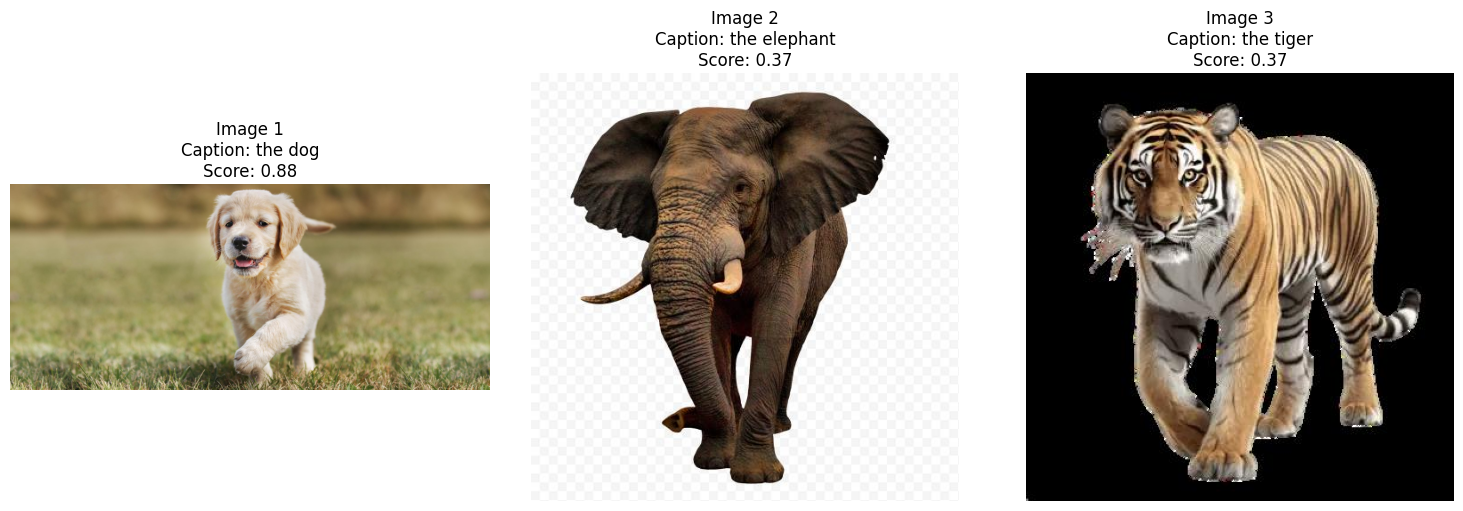

In [ ]:
# demo
def main():
    print("Multimodal RAG Demo (Enhanced)")
    print("=============================")
    print("1. Upload and process your own PDF")
    print("2. Run demo with sample data")

    choice = input("Enter your choice (1 or 2): ")

    if choice == "1":
        rag = process_and_query_pdf()
        return rag
    else:

        return run_sample_demo()

# run demo
if __name__ == "__main__":
    rag = main()